In [1]:
from collections import Counter
import time

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sn
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T

from model import SAT
from util import CocoCaptionDataset

In [2]:
checkpoint_path = "logs/default/version_74/epoch=79-step=15999-bleu4=0.2454.ckpt"

workers = 6

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SAT.load_from_checkpoint(checkpoint_path, map_location=device).to(device)
model.freeze()

valid_transforms = T.Compose([
    T.Resize(model.hparams.input_size),
    T.CenterCrop(model.hparams.input_size),
    T.ToTensor()
])
valid_ds = CocoCaptionDataset(jsonpath=model.hparams.json, split="test", transforms=valid_transforms)
val_loader = DataLoader(dataset=valid_ds, shuffle=False, batch_size=model.hparams.batch, num_workers=workers, persistent_workers=(True if workers > 0 else False), pin_memory=True)

In [3]:
headers = ["beamk", "temperature", "sample_method", "decoder_noise", "rescore_method", "rescore_reward", "bleu1", "bleu2", "bleu3", "bleu4", "cosine_similarity", "gleu", "perplexity"]

# New table
results = pd.DataFrame(columns=headers)
# Continue from old table
# results = pd.read_csv("data/results.csv", delimiter=",")
results

,beamk,temperature,sample_method,decoder_noise,rescore_method,rescore_reward,bleu1,bleu2,bleu3,bleu4,cosine_similarity,gleu,perplexity


In [4]:
# Parameter ranges for decoding and ranking captions
beamks = [5, 20]  # random Choice
max_gen_length = 32
temperatures = [0.7, 1.2]  # uniform sampling
sample_methods = ["beam", "multinomial"]  # beam, multinomial
decoder_noises = [0.0]  # random Choice
rescore_methods = ["LN", "BAR"]  # random Choice, "NONE", "LN", "WR", "BAR"
# WR reward increase with beam width
# BAR >1.0 is best for most beam width
rescore_rewards = [0.6, 1.3]  # uniform sampling

num_trials = 10  # Number of trials

In [5]:
# random grid search for N trials
t0 = time.time()
for n_iter in range(num_trials):
    print(f"\nStart Iteration {n_iter+1} of {num_trials}")

    # Sample the captioning parameters
    beamk = np.random.choice(beamks)
    temperature = np.random.uniform(temperatures[0], temperatures[1])
    sample_method = np.random.choice(sample_methods)
    decoder_noise = np.random.choice(decoder_noises)
    rescore_method = np.random.choice(rescore_methods)
    rescore_reward = np.random.uniform(rescore_rewards[0], rescore_rewards[1])

    print(f"{beamk=}. {temperature=:.2f}. {sample_method=} {decoder_noise=} {rescore_method=}. {rescore_reward=:.2f}")

    row = {"beamk": beamk, "temperature": temperature, "sample_method": sample_method, "decoder_noise": decoder_noise, "rescore_method": rescore_method, "rescore_reward": rescore_reward}

    t1 = time.time()
    batch_metrics_total = Counter({})
    for batch_idx, batch in enumerate(val_loader):
        batch = [x.to(device) for x in batch]
        metrics = model.val_batch(batch, beamk=beamk, max_gen_length=max_gen_length, temperature=temperature, sample_method=sample_method, decoder_noise=decoder_noise, rescore_method=rescore_method, rescore_reward=rescore_reward)
        batch_metrics_total += Counter(metrics)

        duration = time.time()-t1
        avg_duration = duration/(batch_idx+1)
        print(f"\rBatch {batch_idx+1}/{len(val_loader)}. Duration: {duration:.2f}s. Average Batch Time: {avg_duration:.2f}s.", end="")
        if batch_idx+1>=4: break

    batch_metrics_avg = {k: v/(batch_idx+1) for k, v in batch_metrics_total.items()}
    row.update(batch_metrics_avg)
    results = results.append(row, ignore_index=True)

duration = time.time()-t0
print(f"\nDone. Total time={duration:.1f}s.")


Start Iteration 1 of 10
beamk=20. temperature=0.77. sample_method='beam' decoder_noise=0.0 rescore_method='LN'. rescore_reward=0.87
Batch 4/12. Duration: 48.18s. Average Batch Time: 12.05s.
Start Iteration 2 of 10
beamk=5. temperature=0.84. sample_method='multinomial' decoder_noise=0.0 rescore_method='BAR'. rescore_reward=0.77
Batch 4/12. Duration: 33.26s. Average Batch Time: 8.31s.
Start Iteration 3 of 10
beamk=5. temperature=0.80. sample_method='multinomial' decoder_noise=0.0 rescore_method='LN'. rescore_reward=1.24
Batch 4/12. Duration: 31.70s. Average Batch Time: 7.93s.
Start Iteration 4 of 10
beamk=20. temperature=0.96. sample_method='beam' decoder_noise=0.0 rescore_method='BAR'. rescore_reward=1.06
Batch 4/12. Duration: 41.55s. Average Batch Time: 10.39s.
Start Iteration 5 of 10
beamk=5. temperature=1.13. sample_method='multinomial' decoder_noise=0.0 rescore_method='LN'. rescore_reward=0.83
Batch 4/12. Duration: 53.47s. Average Batch Time: 13.37s.
Start Iteration 6 of 10
beamk=5

In [6]:
results.to_csv("data/results.csv", header=True, index=False)

In [7]:
results.sort_values(by="bleu4", ascending=False)

,beamk,temperature,sample_method,decoder_noise,rescore_method,rescore_reward,bleu1,bleu2,bleu3,bleu4,cosine_similarity,gleu,perplexity
0,20,0.767227,beam,0.0,LN,0.870703,0.655226,0.474856,0.340273,0.240055,0.639311,0.242142,1.920939
3,20,0.957503,beam,0.0,BAR,1.056440,0.642664,0.461799,0.333176,0.238137,0.628785,0.238492,2.798616
8,5,1.170413,beam,0.0,LN,1.074644,0.654042,0.469143,0.336858,0.236325,0.637365,0.239873,5.518969
2,5,0.795644,multinomial,0.0,LN,1.235884,0.603720,0.405012,0.264387,0.169923,0.572757,0.192547,3.551060
1,5,0.842792,multinomial,0.0,BAR,0.768919,0.598040,0.398298,0.258659,0.164931,0.573915,0.189145,4.200200
5,5,0.864642,multinomial,0.0,BAR,0.894494,0.582279,0.383216,0.247063,0.155973,0.565959,0.184576,4.879977
7,5,0.930386,multinomial,0.0,BAR,0.618611,0.590784,0.389944,0.249317,0.154637,0.561509,0.183476,5.497515
6,5,0.732414,multinomial,0.0,BAR,1.254821,0.578561,0.381254,0.243112,0.150123,0.572207,0.180189,18.382190
4,5,1.134015,multinomial,0.0,LN,0.829840,0.547686,0.347432,0.214805,0.128887,0.531454,0.165342,13.205784
9,5,0.996309,multinomial,0.0,BAR,1.296366,0.307840,0.181976,0.108404,0.063101,0.423646,0.089970,338.929076


In [8]:
results.columns

Index(['beamk', 'temperature', 'sample_method', 'decoder_noise',
       'rescore_method', 'rescore_reward', 'bleu1', 'bleu2', 'bleu3', 'bleu4',
       'cosine_similarity', 'gleu', 'perplexity'],
      dtype='object')

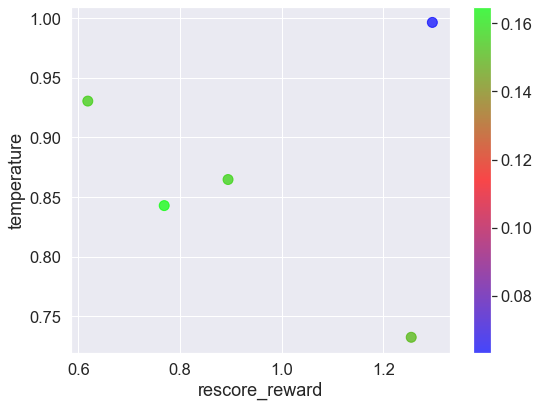

In [13]:
subset = results
fig = plt.figure(figsize=[8, 6])
ax = plt.gca()
subset = subset[subset["beamk"]==5]
subset = subset[subset["rescore_method"]=="BAR"] #"NONE", "LN", "WR", "BAR"
# beamk, temperature, rescore_reward
x = "rescore_reward"
y = "temperature"
c = "bleu4"
im = ax.scatter(
    x=subset[x], y=subset[y],
    s=100, alpha=0.7,
    c=subset[c], cmap="brg",
)
fig.colorbar(im, ax=ax)
ax.set_xlabel(x)
ax.set_ylabel(y)
fig.tight_layout()

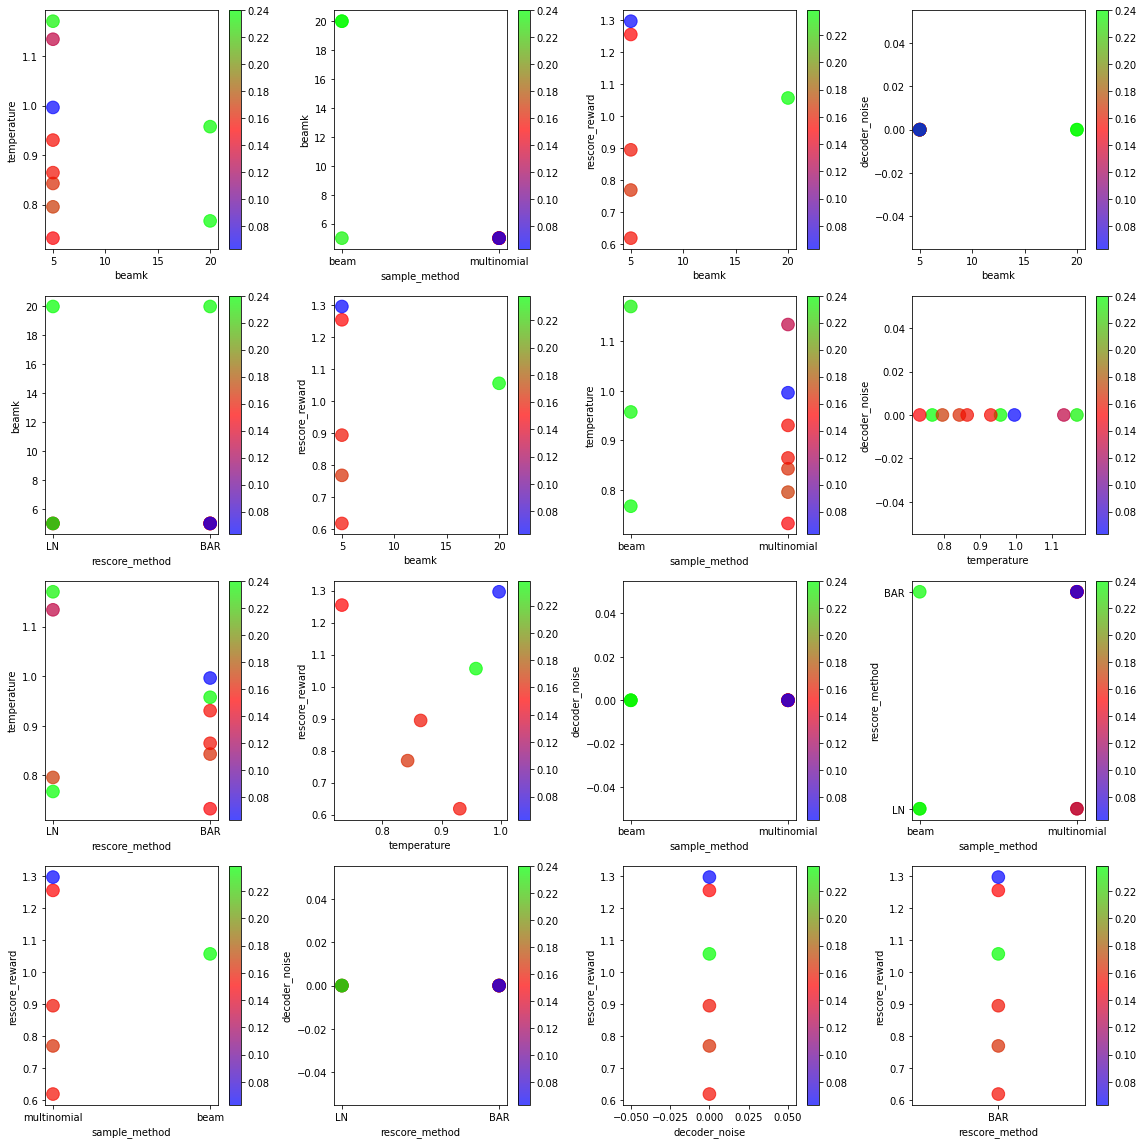

In [10]:
subset = results
# subset = subset[subset["beamk"]==5]
scale = 4
size = 40
color = "bleu4"
plots = [ # x, y, color
    ["beamk", "temperature", color],
    ["sample_method", "beamk", color],
    ["beamk", "rescore_reward", color],
    ["beamk", "decoder_noise", color],
    ["rescore_method", "beamk", color],
    ["beamk", "rescore_reward", color],

    ["sample_method", "temperature", color],
    ["temperature", "decoder_noise", color],
    ["rescore_method", "temperature", color],
    ["temperature", "rescore_reward", color],

    ["sample_method", "decoder_noise", color],
    ["sample_method", "rescore_method", color],
    ["sample_method", "rescore_reward", color],

    ["rescore_method", "decoder_noise", color],
    ["decoder_noise", "rescore_reward", color],

    ["rescore_method", "rescore_reward", color],
]
rr = int(np.ceil(np.sqrt(len(plots)))) 
fig = plt.figure(figsize=[scale*rr, scale*rr])
for i, (x, y, c) in enumerate(plots):
    fig.add_subplot(rr, rr, i+1)
    ax = plt.gca()

    if "rescore_reward" in [x, y]:
        # Remove the methods that don't use the reward
        df = subset[(subset["rescore_method"]!="NONE")&(subset["rescore_method"]!="LN")]
    else:
        df = subset

    im = ax.scatter(
        x=df[x], y=df[y],
        s=size*scale, alpha=0.7,
        c=df[c], cmap="brg",
    )
    fig.colorbar(im, ax=ax)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
fig.tight_layout()

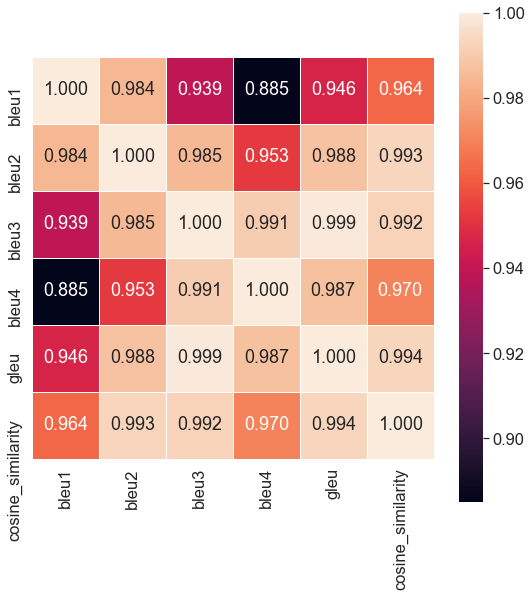

In [11]:
scale = 1.5
cols = ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'gleu', 'cosine_similarity']
data = results[cols].corr(method='pearson')
fig = plt.figure(figsize=(scale*len(cols), scale*len(cols)))
sn.set(font_scale=scale)  # Label size
ax = sn.heatmap(data,
    annot=True, fmt=".3f", annot_kws={"size": scale*12},
    # cmap='Blues',
    # vmin=0, vmax=1,
    xticklabels=cols,  yticklabels=cols,
    square=True, linewidths=0.5
)